In [20]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
from datasets import load_dataset

ds = load_dataset("ylecun/mnist", download_mode='reuse_cache_if_exists')

Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 213237.89 examples/s]


In [22]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [23]:
type(ds)

datasets.dataset_dict.DatasetDict

In [24]:
type(ds['train'])

datasets.arrow_dataset.Dataset

In [25]:
X_train = ds['train']['image']
Y_train = ds['train']['label']
X_test = ds['test']['image']
Y_test = ds['test']['label']

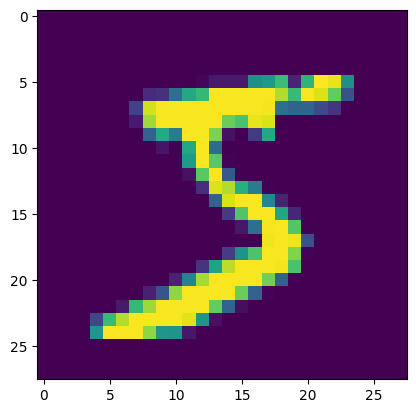

In [26]:
plt.imshow(X_train[0])

In [27]:
X_train = np.array(X_train).reshape(-1, 28*28)

In [28]:
X_train.shape

(60000, 784)

In [29]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [30]:
X_train = torch.from_numpy(X_train).float()
Y_train = torch.tensor(Y_train)
X_test = torch.from_numpy(np.array(X_test)).reshape(-1, 28*28).float()
Y_test = torch.tensor(Y_test)

In [36]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

model = MyNet()

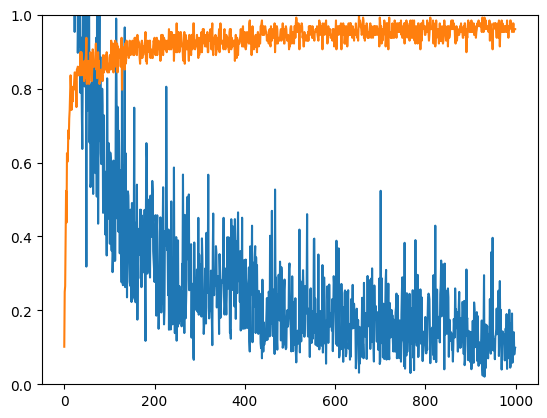

In [37]:
B = 128
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
losses, accs = [], [] 
for i in range(1000):
    samp =np.random.randint(0, X_train.shape[0], size=(B))
    X = X_train[samp]
    Y = Y_train[samp].long()
    optim.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    acc = (cat == Y).float().mean()
    accs.append(acc)
    loss = loss_function(out, Y)
    loss.backward()
    optim.step()
    losses.append(loss.item())
plt.ylim(0, 1)
plt.plot(losses)
plt.plot(accs)

In [38]:
print(losses[-1], accs[-1])


0.09905562549829483 tensor(0.9609)


In [39]:
with torch.no_grad():
        out = model(X_test)
        cat = torch.argmax(out, dim=1)
        acc = (cat == Y_test).float().mean()
        print(acc)

tensor(0.9545)


In [43]:
model.l1.weight.detach().numpy().shape

(128, 784)

In [48]:
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)

In [49]:
l1[:] = model.l1.weight.detach().numpy().T
l2[:] = model.l2.weight.detach().numpy().T

In [59]:
# numpy forward pass 
def forward(x):
    x = x.dot(l1)
    x = np.maximum(0, x)
    x = x.dot(l2)
    return x
Y_test_pred_out = forward(X_test.numpy())
Y_test_pred = np.argmax(Y_test_pred_out, axis=1)

In [54]:
Y_test_pred.shape

(10000,)

In [55]:
(Y_test.numpy() == Y_test_pred).mean()

0.9549

In [61]:
# training in numpy 
np.log(np.exp(Y_test_pred_out[0]).sum())

25.21537

In [62]:
Y_test[0]

tensor(7)

In [63]:
Y_test_pred_out[0]

array([-10.00519  , -13.7315645,  10.01836  ,   9.775846 ,  -2.2564392,
        -1.226856 , -10.423952 ,  25.21537  ,   0.569459 ,   3.8982882],
      dtype=float32)

In [69]:
loss = 0
size = Y_test.shape[0]
for i in range(size):
    loss += -Y_test_pred_out[i, Y_test[i]] + np.log(np.exp(Y_test_pred_out[i]).sum())
loss /= size
print(loss)

0.17608058372735977


In [73]:
size = Y_test_pred_out.shape[0]
ret = -Y_test_pred_out[range(size), Y_test] + np.log(np.exp(Y_test_pred_out).sum(axis=1))


In [77]:
ret

array([0.0000000e+00, 0.0000000e+00, 6.0305595e-03, ..., 2.0980835e-05,
       0.0000000e+00, 1.5068054e-04], dtype=float32)

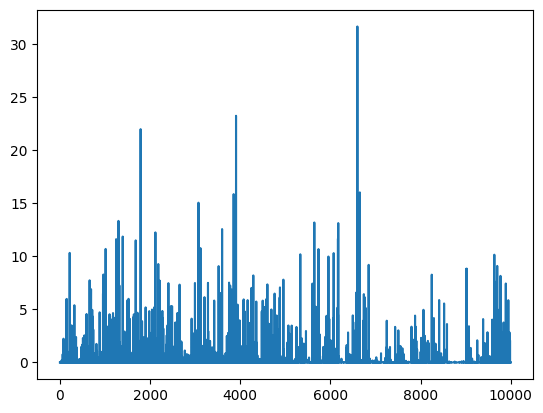

In [78]:
plt.plot(ret)

In [81]:
np.argmax(ret)

6597

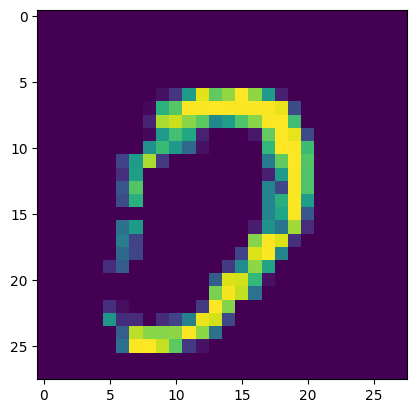

In [80]:
plt.imshow(X_test.reshape(-1, 28, 28)[np.argmax(ret)])

In [121]:
rank = sorted(list(zip(range(ret.shape[0]), ret)), key=lambda a: a[1], reverse=True)

In [122]:
G = 10
X_bad = X_test[[x[0] for x in rank[:G*G]]]

In [123]:
X_bad.shape

torch.Size([100, 784])

In [125]:
X_bad.reshape((G, 28*G, 28)).shape

torch.Size([10, 280, 28])

In [126]:
np.concatenate(X_bad.reshape((G, 28*G, 28)).numpy(), axis=1).shape

(280, 280)

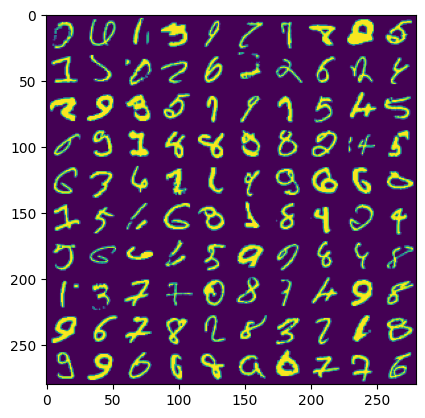

In [127]:
plt.imshow(np.concatenate(X_bad.reshape((G, 28*G, 28)).numpy(), axis=1))

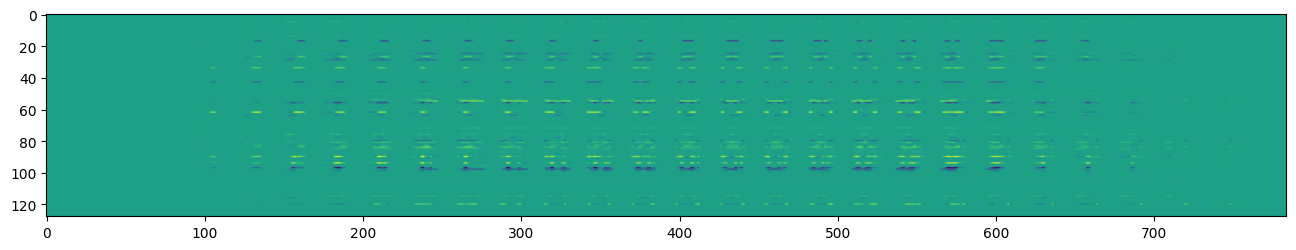

In [135]:
plt.figure(figsize=(16, 16))
plt.imshow(model.l1.weight.grad)

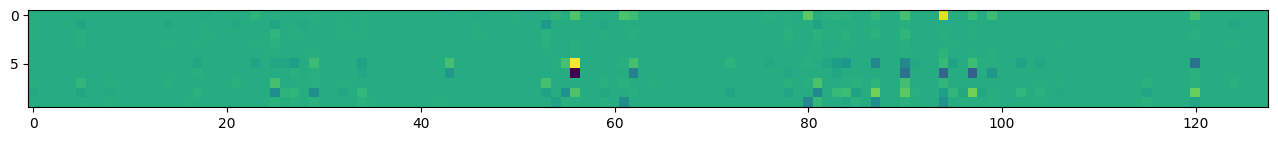

In [138]:
plt.figure(figsize=(16, 16))
plt.imshow(model.l2.weight.grad)